In [36]:
# Импортируем нужные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [37]:
# Исходные данные
A80 = 40.8 # деформация перед разрушением в направлении параллельном направлению проката
r0, r45, r90 = 1.769, 1.661, 2.225 # коэффициенты пластической анизатропии
t = 1.2 # толщина материала
A80min = None # минимальное среди трех направлений значение деформации перед разрушением. Если неопределено, то принимаем равным деформации в напревлении проката.

In [38]:
# Расчет усредненного коэффициента пластической анизатропии и окончательное назначение A80
r = (r0 + 2*r45 + r90) / 4 # усредненный коэффициент пластической анизатропии
A80min = A80min if A80min is not None else A80 # минимальное среди трех направление значение деформации перед разрушением
points = {} # в словарь будем записывать результаты

In [39]:
# Расчет предельной деформации при одноосном растяжении (точка TE). Формулы (14)-(16) в статье.
term_A = 0.0626 * A80 ** 0.567
term_t = (t - 1) * (0.12 - 0.0024 * A80)
SVL_t = term_A + term_t # числитель уравнения 14
strain_ratio = 0.797 * r ** 0.701
denominator = np.sqrt(1 + strain_ratio ** 2) # знаменатель уравнения 14
eps3_TE = -SVL_t / denominator # уравнение 14
eps2_TE = -SVL_t * strain_ratio / denominator # уравнение 15
eps1_TE = (1 + strain_ratio) * SVL_t / denominator # уравнение 16
point_TE = {'eps1': eps1_TE, 'eps2': eps2_TE} # словарь, хранящий полученные координыты точки TE
points['TE'] = point_TE
print (f'Координаты точки TE: ε₁ = {point_TE['eps1']:.3f}, ε₂ = {point_TE['eps2']:.3f}')

Координаты точки TE: ε₁ = 0.728, ε₂ = -0.399


In [40]:
# Расчет предельной деформации при плоском растяжении (точка PS). Формула (20) в статье.
eps1_PS = 0.0084 * A80 + 0.0017 * A80 * (t - 1)
point_PS = {'eps1': eps1_PS, 'eps2': 0.0}
points['PS'] = point_PS
print (f'Координаты точки PS: ε₁ = {point_PS['eps1']:.3f}, ε₂ = {point_PS['eps2']:.3f}')

Координаты точки PS: ε₁ = 0.357, ε₂ = 0.000


In [41]:
# Расчет предельной деформации при двуосном растяжении (точка BI). Формулы (21), (25), (26)
A80min = A80min or A80
eps1_BI_1mm = 0.005 * A80min + 0.25 # формула 21. Фактически это предельная деформация в направлении приложенной нагрузки для образца толщиной 1 мм.
eps1_BI = 0.00215 * A80min + 0.25 + 0.00285 * A80min * t # формула 25. Это предельная деформация для заданной толщины, но при условии, что тольщина не превышает расчетную критическую (см. формулу 26) 
t_trans = 1.5 - (0.00215 * A80min) / (0.6 + 0.00285 * A80min) # формула 26. Критическая толщина, выше которой формула 25 неприменима
# Проверяем применима ли формула 25 и если нет, используем формулу 21
if t <= t_trans:
    pass
else:
    eps1_BI = eps1_BI_1mm

point_BI =  {'eps1': eps1_BI, 'eps2': eps1_BI}
points['BI'] = point_BI
print (f'Координаты точки BI: ε₁ = {point_BI['eps1']:.3f}, ε₂ = {point_BI['eps2']:.3f}')

Координаты точки BI: ε₁ = 0.477, ε₂ = 0.477


In [42]:
# Расчет предельной деформации в промежуточном состоянии (точка IM). Формулы (27), (32).
eps1_IM_1mm = 0.0062 * A80 + 0.18 # формула 27. Тоже для толщины материала 1 мм.
eps1_IM = eps1_IM_1mm + 0.0027 * A80 * (t - 1) # формула 32
# Проверяем применима ли формула 32 и если нет, используем формулу 27
if t <= t_trans:
   pass
else:
    eps1_IM = eps1_IM_1mm
eps2_IM = 0.75*eps1_IM # согласно формуле 32
point_IM =  {'eps1': eps1_IM, 'eps2': eps2_IM}
points['IM'] = point_IM
print (f'Координаты точки IM: ε₁ = {point_IM['eps1']:.3f}, ε₂ = {point_IM['eps2']:.3f}')

Координаты точки IM: ε₁ = 0.455, ε₂ = 0.341


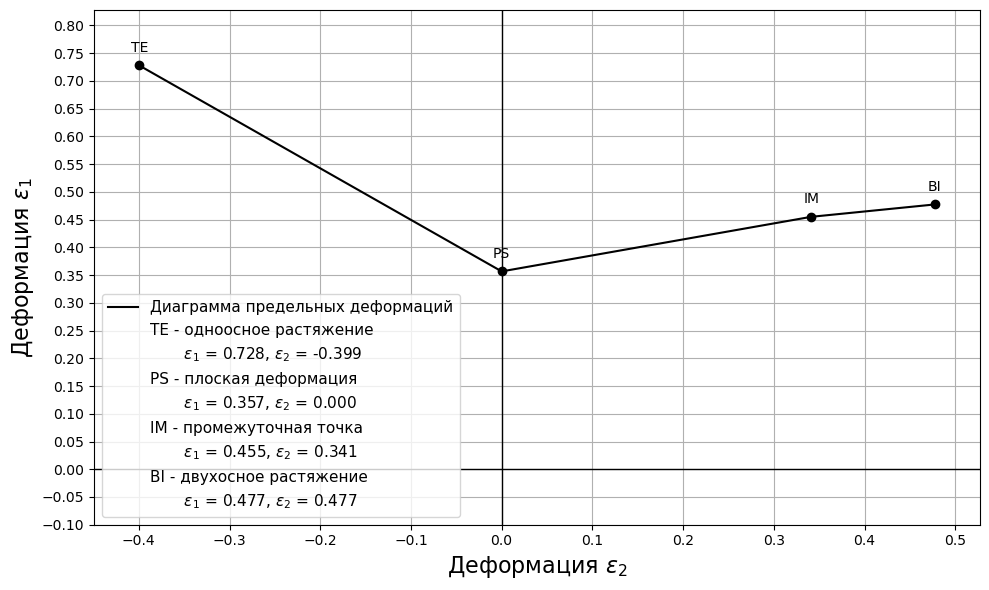

In [69]:
# Построение диаграммы штампуемости
#
# Сортируем ключи словаря points по значению каждого из вложенных словарей eps2 (чтобы идти слева направо)
labels = sorted(points.keys(), key=lambda k: points[k]['eps2'])
# Извлекаем координаты в отсортированном порядке
x_vals = [points[k]['eps2'] for k in sorted_keys]
y_vals = [points[k]['eps1'] for k in sorted_keys]
# Строим график
plt.figure(figsize=(10, 6))

 # Основные точки FLC
plt.plot(x_vals, y_vals, 'black', label='Диаграмма предельных деформаций')
plt.scatter(x_vals, y_vals, color='black', zorder=5)


# Аннотации точек
for i, label in enumerate(labels):
    plt.annotate(label, (x_vals[i], y_vals[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Подписи точек
plt.plot([], [], ' ', label='TE - одноосное растяжение')
plt.plot([], [], ' ', label=f"       $\\varepsilon_1$ = {y_vals[0]:.3f}, $\\varepsilon_2$ = {x_vals[0]:.3f}")

plt.plot([], [], ' ', label='PS - плоская деформация')
plt.plot([], [], ' ', label=f"       $\\varepsilon_1$ = {y_vals[1]:.3f}, $\\varepsilon_2$ = {x_vals[1]:.3f}")

plt.plot([], [], ' ', label='IM - промежуточная точка')
plt.plot([], [], ' ', label=f"       $\\varepsilon_1$ = {y_vals[2]:.3f}, $\\varepsilon_2$ = {x_vals[2]:.3f}")

plt.plot([], [], ' ', label='BI - двухосное растяжение')
plt.plot([], [], ' ', label=f"       $\\varepsilon_1$ = {y_vals[3]:.3f}, $\\varepsilon_2$ = {x_vals[3]:.3f}")

# Настройки графика
# Подписи осей
plt.xlabel("Деформация $\\varepsilon_2$", fontsize=16)
plt.ylabel("Деформация $\\varepsilon_1$", fontsize=16)

# Добавление сетки на график
plt.grid(True)

# Добавляем толщину на оси x и y
plt.axhline(0, color='black', linewidth=1.0)
plt.axvline(0, color='black', linewidth=1.0)

# Автоматический масштаб осей
plt.xlim(min(x_vals) - 0.05,max(x_vals) + 0.05)
plt.ylim(-0.1, max(y_vals) + 0.1)

# Настройка числовых осей
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

# Ностройка отображения легенды
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()